<a href="https://colab.research.google.com/github/agnanp/learntf/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Text preprocessing function
str_punc = string.punctuation.replace(',', '').replace("'",'')

def clean(text):
    global str_punc
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = text.lower()
    return text    

In [ ]:
# Read dataset & Preprocess text
df_train = pd.read_csv('/content/drive/MyDrive/tugas/train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('/content/drive/MyDrive/tugas/val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('/content/drive/MyDrive/tugas/test.txt', names=['Text', 'Emotion'], sep=';')

X_train = df_train['Text'].apply(clean)
y_train = df_train['Emotion']

X_test = df_test['Text'].apply(clean)
y_test = df_test['Emotion']

X_val = df_val['Text'].apply(clean)
y_val = df_val['Emotion']

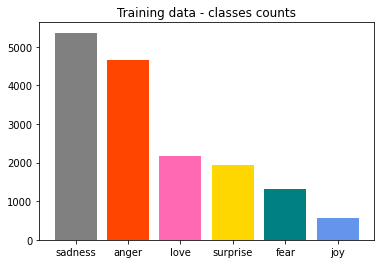

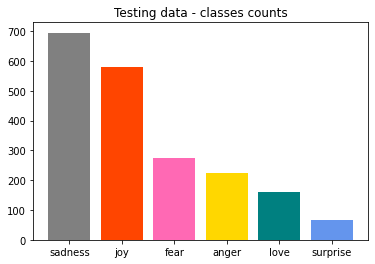

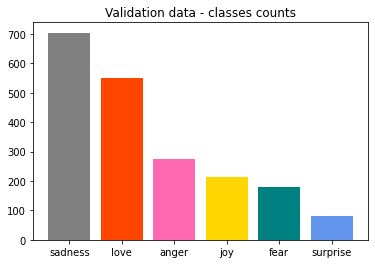

In [ ]:
# Visualize classes counts
colors = np.array(["gray", 'orangered', 'hotpink', 'gold', 'teal', 'cornflowerblue'])

plt.bar(y_train.unique(), y_train.value_counts(), color=colors)
plt.title("Training data - classes counts")
plt.show()

plt.bar(y_test.unique(), y_test.value_counts(), color=colors)
plt.title("Testing data - classes counts")
plt.show()

plt.bar(y_val.unique(), y_val.value_counts(), color=colors)
plt.title("Validation data - classes counts")
plt.show()

In [ ]:
# Encode labels
# Sudah disediakan beberapa variable, lengkapi variabel tersebut
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_val = y_val.reshape(-1,1)

In [ ]:
# Tokenize words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 16185


In [ ]:
# Read GloVE embeddings
path_to_glove_file = '/content/drive/MyDrive/tugas/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200
hits = 0
misses = 0
embeddings_index = {}

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 15069 words (1115 misses)


In [ ]:
# Build neural network architecture
model = Sequential([
                    Embedding(vocabSize, embedding_dim, input_length=256),
                    Bidirectional(LSTM(64, return_sequences=True)),
                    Dropout(0.2),
                    Bidirectional(LSTM(32, return_sequences=True)),
                    Dropout(0.2),
                    Bidirectional(LSTM(16)),
                    Dense(8, activation='relu'),
                    Dropout(0.2),
                    Dense(6,activation='softmax')
])
adam = Adam(learning_rate=0.005)
#code here
model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 200)          3237000   
                                                                 
 bidirectional (Bidirectiona  (None, 256, 128)         135680    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256, 128)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 256, 64)          41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256, 64)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               1

In [ ]:
#Callback
callback = EarlyStopping(
    #code here (contains at least : monitor, patience, restore_best_weights)
    monitor='val_loss',
    min_delta=0.001,
    patience=2,
    restore_best_weights=True,
)

In [ ]:
# Fit model
# code here
NUM_EPOCHS = 10
BATCH_SIZE = 64
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/10
250/250 [==============================] - 28s 69ms/step - loss: 1.5936 - accuracy: 0.3284 - val_loss: 1.4986 - val_accuracy: 0.3675
Epoch 2/10
250/250 [==============================] - 16s 66ms/step - loss: 1.3610 - accuracy: 0.4091 - val_loss: 1.2073 - val_accuracy: 0.4370
Epoch 3/10
250/250 [==============================] - 15s 58ms/step - loss: 1.1288 - accuracy: 0.4516 - val_loss: 0.9578 - val_accuracy: 0.5080
Epoch 4/10
250/250 [==============================] - 15s 58ms/step - loss: 0.9482 - accuracy: 0.5008 - val_loss: 0.9029 - val_accuracy: 0.5490
Epoch 5/10
250/250 [==============================] - 15s 59ms/step - loss: 0.7455 - accuracy: 0.6411 - val_loss: 0.5432 - val_accuracy: 0.8325
Epoch 6/10
250/250 [==============================] - 15s 58ms/step - loss: 0.4879 - accuracy: 0.8317 - val_loss: 0.4328 - val_accuracy: 0.8780
Epoch 7/10
250/250 [==============================] - 15s 59ms/step - loss: 0.3539 - accuracy: 0.8958 - val_loss: 0.3148 - val_accuracy:

In [ ]:
model.evaluate(X_val, y_val, verbose=1)

63/63 [==============================] - 2s 25ms/step - loss: 0.3233 - accuracy: 0.9050


[0.3232855796813965, 0.9049999713897705]

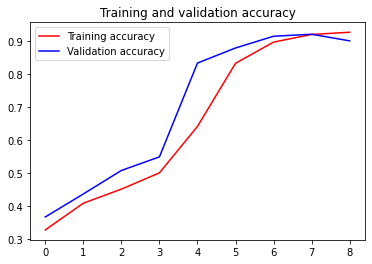

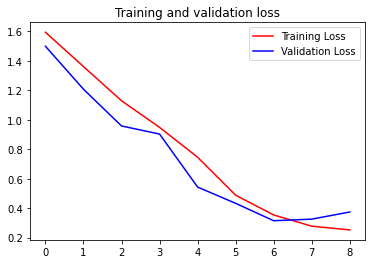

In [ ]:
# Visualize Loss & Accuracy

%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Classify custom sample

sentences = [
            'i do not want others to feel unhappy just because they have to accommodate to me'
            ]
for sentence in sentences:
    print(sentence)
    sentence = clean(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=256, truncating='pre')
    result = le.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n")

i do not want others to feel unhappy just because they have to accommodate to me
sadness : 0.9728308916091919



In [ ]:
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)
    
with open('labelEncoder.pickle', 'wb') as f:
    pickle.dump(le, f)
    
    
model.save('Emotion Recognition.h5')